In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


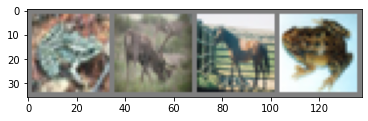

 frog  deer horse  frog


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

#学習データの出力
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
#CNNの定義
#入力層→畳み込み層→プーリング層→畳み込み層→プーリング層→全結合層→全結合層→全結合層→出力層

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
#損失関数とオプティマイザ

import torch.optim as optim　#オプティマイザ用のライブラリ

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#ニューラルネットワークの訓練
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
       # 訓練データから入力画像の行列とラベルを取り出す
        inputs, labels = data

         # 勾配パラメータを０にする
        optimizer.zero_grad()

       # 順伝播 → 逆伝播 → 勾配パラメータの最適化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

         # 損失関数の変化を2000ミニバッチごとに表示
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.169
[1,  4000] loss: 1.843
[1,  6000] loss: 1.646
[1,  8000] loss: 1.572
[1, 10000] loss: 1.483
[1, 12000] loss: 1.436
[2,  2000] loss: 1.368
[2,  4000] loss: 1.345
[2,  6000] loss: 1.314
[2,  8000] loss: 1.290
[2, 10000] loss: 1.256
[2, 12000] loss: 1.257
Finished Training


In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

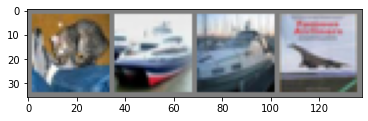

GroundTruth:    cat  ship  ship plane


In [ ]:
#テスト

# 訓練データをランダムに取得
dataiter = iter(testloader)
images, labels = dataiter.next()

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)#入力した画像の行列の最大値（もっとも確率の高いもの）を返す

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog  ship plane plane


In [ ]:
#100000枚のテストデータの統計とラベルごとの予測精度

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 62 %
Accuracy of  bird : 29 %
Accuracy of   cat : 47 %
Accuracy of  deer : 19 %
Accuracy of   dog : 35 %
Accuracy of  frog : 73 %
Accuracy of horse : 65 %
Accuracy of  ship : 51 %
Accuracy of truck : 75 %
